In [1]:
import keras.losses
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, UpSampling2D
from keras.layers import Reshape, Dense, Conv2DTranspose
from keras.losses import BinaryCrossentropy as cross_entropy
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.activations import relu
import numpy as np

<h1>Monet</h1>

In this Notebook, We'll be training a Deep Neural Network to paint using a dataset of 300 Monet Paintings.

<h3>The Data </h3>

The Data which consists of 300 Paintings by Claude Monet is gotten from Kaggle. The images are in .jpg format.

In [2]:
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

dir = pathlib.Path('0/')

train_monet = image_dataset_from_directory(dir, image_size=(256, 256), label_mode=None,
                                           validation_split=0.2, subset='training', seed=123)
test_monet = image_dataset_from_directory(dir, image_size=(256, 256), label_mode=None,
                                           validation_split=0.2, subset='validation', seed=123)

Found 300 files belonging to 1 classes.
Using 240 files for training.
Found 300 files belonging to 1 classes.
Using 60 files for validation.


Here is a visualization of 9 images from the dataset.

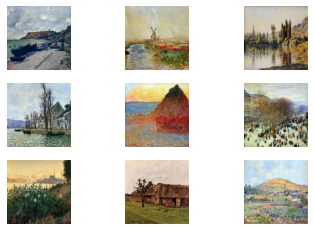

In [4]:
for images in train_monet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

<h2>The Model</h2>
Using Generative Adversial Networks, the model is divided into two parts that are trained simultaneously, the generator and the discriminator.

<h3>The Generator</h3>
The Generator as the name implies generates the image. This is normally do using a random image. But in this case, Autoencoders are used to learn the features of some paintings by Monet (encoder) and tries to generate a new image using those features (decoder). This should be presumably faster than using random noise to start learning

<h3>The Discriminator</h3>
The Discriminator, tries to detect if the images generated by the generator is real or fake. It is initally trained using 7000 real images and 300 monet paintings. A loss function is used to check how good the generator can fool the discriminator and how well the discriminator can detect fake images.

In [5]:
def gen():
    c_autoe = Sequential()
    c_autoe.add(Conv2D(filters=32, kernel_size=(7, 7), padding='same',
                        input_shape=(256, 256, 3)))
    c_autoe.add(Activation('relu'))
    c_autoe.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same'))
    c_autoe.add(Activation('relu'))
    c_autoe.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    c_autoe.add(Activation('relu'))
    c_autoe.add(MaxPooling2D(pool_size=(2, 2)))
    c_autoe.add(Flatten())
    # c_autoe.add(Dense(128))
    # c_autoe.add(Activation('relu'))
    c_autoe.add(Reshape((128, 128, 128)))
    c_autoe.add(UpSampling2D(size=(2, 2)))
    c_autoe.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), padding='same'))
    c_autoe.add(Activation('relu'))
    c_autoe.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), padding='same'))
    c_autoe.add(Activation('relu'))
    c_autoe.add(Conv2DTranspose(filters=32, kernel_size=(7, 7), padding='same'))
    c_autoe.add(Activation('relu'))
    c_autoe.add(Conv2DTranspose(filters=3, padding='same', kernel_size=(3, 3)))
    c_autoe.add(Activation('sigmoid'))
    c_autoe.summary()
    return c_autoe

gen()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      4736      
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      51264     
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 activation_2 (Activation)   (None, 256, 256, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0

the function gen() creates the generator using Tensorflow.keras sequential model.
The generator used convolutional autoencoders. After the input layer, an initial convolutional layer is used with 32 filters and a (7, 7) kernel 